In [19]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
print(df_users.head())

df_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
print(df_rides.head())

df_subscription = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
df_subscription.head()

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


# 1. Загрузка данных

Загружены три источника:
- df_users - информация о пользователях сервиса GoFast
- df_rides - информация о поездках пользователей сервиса GoFast
- df_subscription - информация о типах подписок

Краткая информация о структуре данных
- для таблиц df_users и df_rides есть общая колонка user_id, в которой хранится уникальных индекс для каждого пользователя, по этой колонке можно производить join (в смысле sql) для этих двух таблиц
- в таблице df_subscription хранится развернутая информация о каждом типе подписки - free и ultra

In [20]:
df_rides['date'] = pd.to_datetime(df_rides['date'])
df_rides['month'] = df_rides['date'].dt.month
df_users.duplicated().sum()
print(df_users.duplicated().sum())
print(df_users[['name', 'age', 'city', 'subscription_type']].duplicated().sum())
df_users = df_users.drop_duplicates()
print(df_users.duplicated().sum())

31
58
0


# 2. Предобработка данных
## 2.1 Пропуски

Пропусков в данных не обнаружено - использовался метод *df.info()*

## 2.2 Дубликаты

Дубликаты искались двумя способами:
- df.duplicated().sum()
- df_users[['список полей не включая индекс user_id']].duplicated().sum()

*df.duplicated().sum()* показал, что дубликаты есть только в таблице **df_users**
Для этой таблицы:

- df_users.duplicated().sum() = 31
- df_users[['name', 'age', 'city', 'subscription_type']].duplicated().sum() = 58

Второе значение больше - так как есть варианты для пользователей, когда все 4 значения полей **'name', 'age', 'city', 'subscription_type'** идентичны, но индексы ('user_id') тем не менее разные - из чего я делаю выводы что разные индексы говорят о том что это все таки разные пользователи, у которых совпадают все 4 значения вышеприведенных полей. А вот значение *df.duplicated().sum() = 31* говорит о том, что есть 31 дубликат для таблицы df_users у которых совпадают все поля включая индекс 'user_id' (возможно это следствие технической ошибки) и в даннм случае дубликаты можно удалить так как они не несут никакой информации.

In [21]:
def plot_sub_plots(df, plot_columns):
    fig, axes = plt.subplots(1+len(df.columns)//plot_columns, plot_columns, figsize=(20, 30))
    for col, axis in zip(df.columns, axes.flat):
        df.hist(column = col, ax=axis)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64
subscription_type
free     0.544329
ultra    0.455671
Name: count, dtype: float64


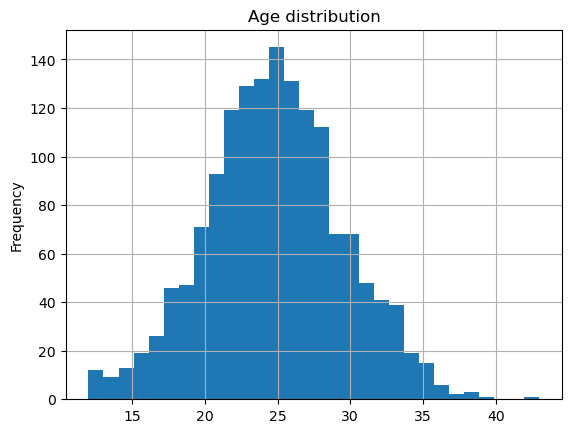

user_id
1411    7211.007745
1422    7066.003772
1361    6908.491343
1471    6760.940067
1477    6724.932981
Name: distance, dtype: float64
user_id
1069    0.855683
925     2.570787
1223    4.329506
861     6.784447
796     7.097072
Name: distance, dtype: float64


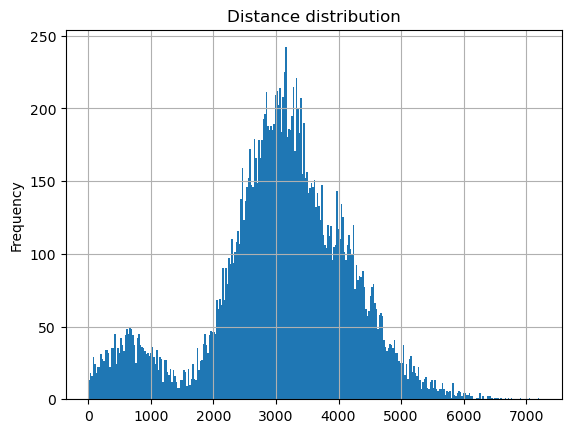

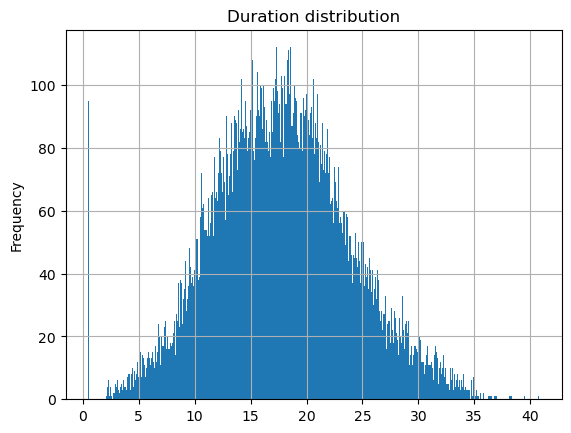

       user_id  distance   duration       date  month
7841       796  7.097072  10.026614 2021-11-26     11
8658       861  6.784447   6.015656 2021-07-21      7
9541       925  2.570787   3.011018 2021-10-19     10
11555     1069  0.855683  10.001902 2021-01-31      1
13690     1223  4.329506   4.008958 2021-05-22      5
count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64
count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64
count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64
       user_id     distance  duration       date  month
8676       8

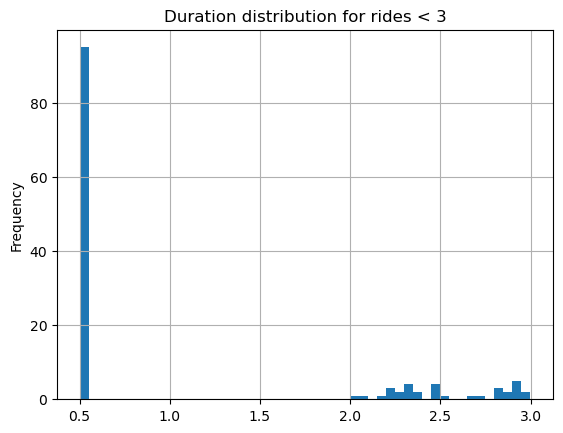

95


,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


In [22]:
print(df_users['city'].value_counts())
print(df_users['subscription_type'].value_counts() / df_users['subscription_type'].count())
plot1 = df_users['age'].plot(kind='hist', title='Age distribution', bins = 30, grid=True)
plt.show()
print(df_rides.groupby(['user_id'])['distance'].max().sort_values(ascending=False).head())
print(df_rides.groupby(['user_id'])['distance'].min().sort_values(ascending=True).head())
plot2 = df_rides['distance'].plot(kind='hist', title='Distance distribution', bins = 300, grid=True)
plt.show()
plot3 = df_rides['duration'].plot(kind='hist', title='Duration distribution', bins = 500, grid=True)
plt.show()
print(df_rides[df_rides['distance'] < 10])
print(df_users['age'].describe())
print(df_rides['distance'].describe())
print(df_rides['duration'].describe())
print(df_rides[df_rides['duration'] < 3].sort_values(by='duration', ascending=False))
plot4 = df_rides[df_rides['duration'] < 3]['duration'].plot(kind='hist', title='Duration distribution for rides < 3', bins = 50, grid=True)
plt.show()
print(df_rides[df_rides['duration'] == 0.5]['duration'].count())
df_rides[df_rides['duration'] == 0.5].head()

# 3. Исследовательский анализ данных

## 3.1 Частота встречаемости городов
Данные в таблице **df_users** сгруппированы по 8 городам, максимальное количество пользователей в г. Пятигорск, минимальное - в г. Москва. Чем можно объяснить такое распределение? Москва очевидно больше Пятигорска но в данной выборке пользователей из Москвы примерно в полтора раза меньше - я предполагаю что в Москве больше конкурентных сервисов и пользователи распределены между ними.

## 3.2 Cоотношение пользователей с подпиской и без подписки
Пользователей без подписки 54%, пользователей с подпиской **ultra** 46%

## 3.3 Возраст пользователей
Гистограмма распределения пользователей по возрастам показывает распределение, близкое к нормальному. **mean** ~ **median** = 25 лет что говорит об отсутствии выбросов. Гистограмма слева не уходит в ноль так как минимальное значение возраста для всей таблицы **df_users** = 12 лет, что вполне правдоподобно. Выбросов гистограмма тоже не показывает.

## 3.4 Расстояние, которое пользователь преодолел за одну поездку
Гистограмма распределения таблицы **df_rides** по колонке *distance* показывает основной пик в районе 3000 м и дополнительный пик в районе 700 м. Ошибочных значений, которые могли бы увести распределение влево я не увидел так как минимальные 5 значений этого поля все больше нуля - то нет явно ошибочных значений равных 0. Выбросов гистограмма тоже не показывает. Причины вторичного максимума пока непонятны и требуют дополнительного анализа, возможно с построением гистограмм, сгруппированным по городам.

## 3.5 Продолжительность поездок
Гистограмма распределения таблицы **df_rides** по колонке *duration* имеет форму, близкую к нормальному распределению с медианой и средним ~ 17 мин, но имеет место выраженный пик в районе близком к нулю (но не равный нулю). Дополнительная гистогррамма для поездок с длительностью меньше чем 3 мин показала, что длительность со значениями менее чем 2 мин в данных обрезана и эти данные все перемещены в бин со значением = 0.5 мин и таких значений 95. Эти данные относятся к разным пользователям и значение *distance* для них отличны от 0.

Я предполагаю, что для таких записей произошло искажение значения *duration* с установкой его в 0.5 и так как установить реальное значение *duration* не представляется возможным я предлагаю пока оставить это как есть и посмотреть на эти данные в разрезе подписок и городов в следующем разделе - после этого можно будет принять решение - оставить их как есть, заполнить значение *duration* нулем или просто удалить все такие записи.


1213     244.210438
5952     266.123499
2656     280.964769
463      307.532350
2422     327.869305
           ...     
32      5335.212090
2294    5371.478730
4692    5391.971747
4136    5419.684636
6312    5699.769662
Name: distance, Length: 6500, dtype: float64

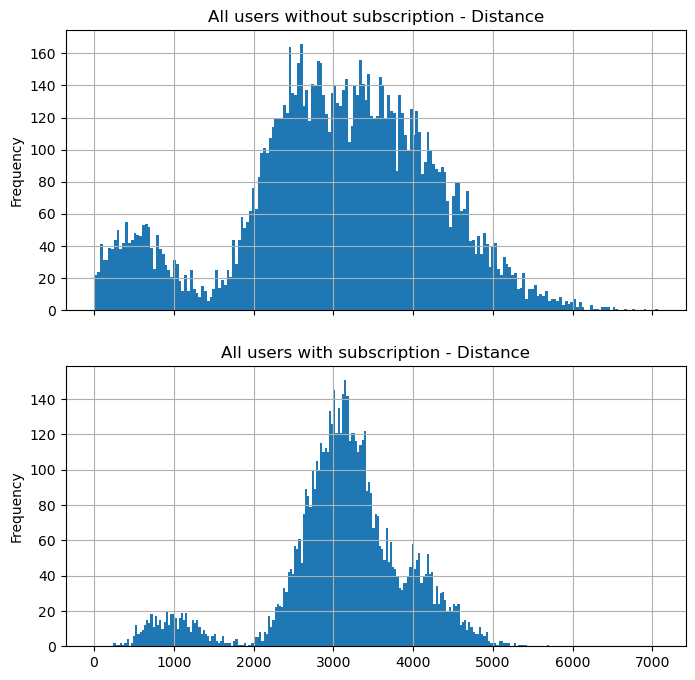

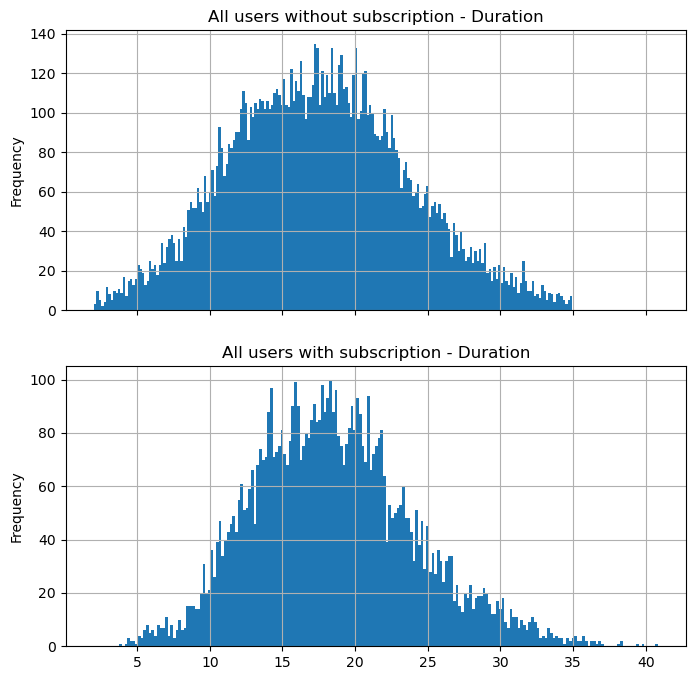

In [23]:
df_ur = df_users.merge(df_rides)
df_all = df_ur.merge(df_subscription)
df_all
df_all_with_subscription = df_all[df_all['subscription_type'] == 'ultra']
df_all_without_subscription = df_all[df_all['subscription_type'] == 'free']
fig1, axes1 = plt.subplots(nrows=2, ncols=1,sharex=True, figsize=(8,8))
fig2, axes2 = plt.subplots(nrows=2, ncols=1,sharex=True, figsize=(8,8))
axes1[0].set_title('All users without subscription - Distance')
axes2[0].set_title('All users without subscription - Duration')
axes1[1].set_title('All users with subscription - Distance')
axes2[1].set_title('All users with subscription - Duration')
bins = 200

df_all_without_subscription = df_all_without_subscription.loc[df_all_without_subscription['duration'] != 0.5]

df_all_without_subscription['distance'].plot(kind='hist', bins = bins, grid=True, ax = axes1[0])
df_all_with_subscription['distance'].plot(kind='hist', bins = bins, grid=True, ax = axes1[1])
df_all_without_subscription['duration'].plot(kind='hist', bins = bins, grid=True, ax = axes2[0])
df_all_with_subscription['duration'].plot(kind='hist', bins = bins, grid=True, ax = axes2[1]);

df_all_with_subscription['distance'].sort_values(ascending=True)

# 4. Объединение данных
## 4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм

Данные из трех источников объелинены в один df_all

## 4.2 Создайте ещё два датафрейма из df_all - c данными о пользователях с подпиской и без

Созданы dataframes df_all_with_subscription и df_all_without_subscription

## 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

Из данной визуализации видно, что для пользователей без подписки значения продолжительности поездки менее чем 2 мин отсутствуют и присутствует ряд значений которые равны == 0.5 мин что приводит к появлению четкого выброса слева у гистограммы **All users without subscription - Duration**. Я это связываю с технической ошибкой и удаляю эти данные - их количество 95. После удаления выброс на гистограмме пропал. 

Общий вид диаграмм Duration близок к нормальному - есть максимум в районе 17 мин и этому значению примерно равны медиана и среднее.
Что касается диаграмм Distance - то тут помимо основного максимума в районе 3000 м есть и вторичный максимум в районе 1000 м для пользователей с подпиской и 500 м для пользователей без подписки. Кроме того, для полльзователей без подписки диаграмма расстояния прижата к левой оси - то есть есть какое то количество поездок с очень малым расстоянием - но не равным 0 (то есть это не техническая ошибка).

In [24]:
df_all_without_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [63]:
df_all['revenue'] = df_all.apply(lambda row: row.loc['start_ride_price'] + row.loc['minute_price'] * np.ceil(row.loc['duration']), axis = 1)
df_all.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,revenue
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,156.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,96.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,42.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,114.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,162.0


In [64]:

df_all_grouped = pd.pivot_table(df_all,
               index=["user_id", "month"],
               values=["distance", "duration", "revenue", "name"],
               aggfunc={"distance": "sum", "duration": ["sum", len], "name" : "first"})
#df_all_grouped.columns = ['length of all rides', 'quantity of all rides', 'duration of all rides']
df_all_grouped


distance duration                name
                        sum      len        sum    first
user_id month                                           
1       1       7027.511294        2  41.416640     Кира
        4        754.159807        1   6.232113     Кира
        8       6723.470560        2  44.776802     Кира
        10      5809.911100        2  31.578017     Кира
        11      7003.499363        3  53.397424     Кира
...                     ...      ...        ...      ...
1534    6       3409.468534        2  24.812678  Альберт
        8       7622.453034        2  47.205960  Альберт
        9       4928.173852        1  22.560373  Альберт
        11     13350.015305        4  76.342174  Альберт
        12      2371.711192        1  15.893917  Альберт

[11331 rows x 4 columns]